In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bert-folder/Cleaned_Nepali_dataset.csv
/kaggle/input/bert-folder/raw_dataset/raw_dataset/dataset_dict.json
/kaggle/input/bert-folder/raw_dataset/raw_dataset/validation/state.json
/kaggle/input/bert-folder/raw_dataset/raw_dataset/validation/dataset_info.json
/kaggle/input/bert-folder/raw_dataset/raw_dataset/validation/data-00000-of-00001.arrow
/kaggle/input/bert-folder/raw_dataset/raw_dataset/train/state.json
/kaggle/input/bert-folder/raw_dataset/raw_dataset/train/dataset_info.json
/kaggle/input/bert-folder/raw_dataset/raw_dataset/train/data-00000-of-00001.arrow


In [2]:
!pip install --upgrade pip
!pip install ipywidgets --upgrade
!pip install datasets
!pip install tqdm
!pip uninstall tensorflow -y
!pip uninstall keras -y
!pip install tf-keras  # To satisfy transformers' internal requirement for now
! pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.9 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
Found existing installation: tensorflow 2.17.1
Uninstalling tensorflow-2.17.1:
  Successfully uninstalled tensorflow-2.17.1
Found existing installation: keras 3.5.0
Uninstalling keras-3.5.0:
  Successfully uninstalled keras-3.5.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 55.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.10.0 requires tensorflow==2.17.0, but you have tensorflow 2.17.1 which is incompatible.


## First let's login to huggingface_hub

In [3]:
from huggingface_hub import notebook_login
notebook_login()

## Importing dataset

In [25]:
!cp -R /kaggle/input/bert-folder/raw_dataset/raw_dataset /kaggle/working/

In [26]:
from datasets import Dataset, load_from_disk

dataset = load_from_disk("/kaggle/working/raw_dataset")

train = dataset["train"]
validation = dataset["validation"]

train = train.rename_column("label", "labels")
validation = validation.rename_column("label", "labels")

print(train)
print(validation)

Dataset({
    features: ['text', 'labels'],
    num_rows: 2287
})
Dataset({
    features: ['text', 'labels'],
    num_rows: 572
})


In [27]:
from collections import Counter

for k, v in dataset.items():
    print(k, Counter(dataset[k]['label']))

train Counter({0: 1807, 3: 214, 1: 200, 2: 66})
validation Counter({0: 452, 3: 53, 1: 50, 2: 17})


In [28]:
import datasets
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, datasets.ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))

show_random_elements(dataset["train"])

,text,label
0,भ्रष्टचारी घुसखोरी कानुन दायरा लिएर राम धुलाई गर्दा कसो होला मेयर ज्यु ।,0
1,"जाहा सरकार , प्रहरी प्रसाशन , अदालत न्याय पाउँदैन भनेर बुझे ।",0
2,रास्ट्रपति गरिमामय पद व्यक्ति बिपक्षी दल नेता एउ टा दल नेता हैसियत खिल्ली मजाक उडाए देख्दा रास्ट्रपति सम्मानित पद बेज्जत अपमान ।,0
3,भ्रष्टाचार अन्त्य मेयरजी हरु यता हाजिर गरमत ️ ️ ।,0
4,रवि एउटा व्याक्ति होइन सिङ्गो नेपाली आशा धरोहर ।,0
5,मानवअधिकार वाद नाम कंलक भनौदी कालो मोसो दलेर सडक नघुमाइ नहुने भयो थुक्क कुकुर्नी जता डलर पायो उतै सरल्क तै न्याय यहि ।,0
6,3 जना माहा पुरुष ठिक मन्त्री ज्यु प्रष्ट बुज्न सकिन्छ पद पाटी बचाउदै छिन ।,0
7,ऋषि धमाला चाहिँ भ्रष्ट दलाल चोर नेता हरु चम्चे ।,1
8,रवि बाघ जना झोले कुकुर हरु भुक्दै ।,0
9,न्युज भन्दापनि सुरुकाे 5 मिनेट दिएकाे दम्दार प्रस्तुति चाहिँ गजब लाग्छ ... ।,0


# Preprocessing and Tokenizer

In [29]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name= "Sakonii/distilbert-base-nepali"

tokenizer= AutoTokenizer.from_pretrained(model_name)

In [30]:
# Generating Embeddings
def preprocess_function(document):
    return tokenizer(document["text"], truncation=True, padding='max_length')

train_tokenized= train.map(preprocess_function, batched= False,remove_columns=["text"])
validation_tokenized= validation.map(preprocess_function, batched= False,remove_columns=["text"])

# Convert to DataFrame and reorder columns
train2 = pd.DataFrame(train_tokenized)
train2 = train2[['input_ids', 'attention_mask', 'labels']]  # Set the correct order

# Convert back to Dataset
train_tokenized = Dataset.from_pandas(train2)
train_tokenized = train_tokenized.with_format("torch", columns=["input_ids", "attention_mask", "labels"])

validation2 = pd.DataFrame(validation_tokenized)
validation2 = validation2[['input_ids', 'attention_mask', 'labels']]  # Set the correct order

# Convert back to Dataset
validation_tokenized = Dataset.from_pandas(validation2)
validation_tokenized = validation_tokenized.with_format("torch", columns=["input_ids", "attention_mask", "labels"])



print(validation_tokenized.features.keys())

Map:   0%|          | 0/2287 [00:00<?, ? examples/s]

Map:   0%|          | 0/572 [00:00<?, ? examples/s]

dict_keys(['input_ids', 'attention_mask', 'labels'])


In [31]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Hyperparamter Search

## Compute metrics

In [32]:
from sklearn.metrics import classification_report

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    report = classification_report(y_true=labels, y_pred=predictions, output_dict=True)

    accuracy = report['accuracy']
    recall = report['macro avg']['recall']
    precision = report['macro avg']['precision']
    f1 = report['macro avg']['f1-score']
    return {
        "accuracy": accuracy,
        "recall": recall,
        "precision": precision,
        "f1": f1
    }

## Custom Loss function with class weights

In [34]:
from torch import nn
import torch
from sklearn.utils.class_weight import compute_class_weight

# Number of classes
num_labels = 4

# The labels in Train dataset
labels = train["labels"]

# obtaining class weight with compute_class_weight
class_weights = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(labels),
        y=labels
    )
class_weights = class_weights / np.sum(class_weights)  # Normalizing magnitude for proper gradient updates

# Convert class weights to a PyTorch tensor
class_weights = torch.tensor(class_weights, dtype=torch.float32)
print(class_weights)

# Custom loss function
def compute_loss_func(outputs, labels, num_items_in_batch=None):
    logits = outputs.logits
    weights = class_weights.to(logits.device)
    loss_fct = nn.CrossEntropyLoss(weight=weights)
    loss = loss_fct(logits.view(-1, num_labels), labels.view(-1))
    return loss


tensor([0.0218, 0.1970, 0.5970, 0.1841])


## Wandb for logging

In [36]:
# wandb for logging, get the login key from wandb.ai/authorize
!pip install wandb
import wandb
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
wandb_secret = user_secrets.get_secret("wandb")
wandb.login(key=wandb_secret)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: tamangangel2057 (tamangangel2057-student). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Training Arguments and Trainer

In [37]:
from transformers import TrainingArguments, Trainer
from transformers import EarlyStoppingCallback

output_dir = "/kaggle/working/BERT_Classifier_v2"
run_name= "BERT_v2"

args = TrainingArguments(
    output_dir=output_dir,
    run_name=run_name,
    eval_strategy="epoch",
    per_device_train_batch_size=4, # Each device takes this batch, so 2 T4 GPU each take 4 making 8
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,
    warmup_ratio= 0.1,
    save_strategy="epoch",
    save_on_each_node=True,
    learning_rate=1e-5,
    num_train_epochs=20,
    weight_decay=0.01,
    report_to="wandb",
    push_to_hub=False,
    save_total_limit= 1,
    metric_for_best_model = 'f1',
    load_best_model_at_end=True,
    greater_is_better=True,
    overwrite_output_dir= True,
    bf16=True,
)




## Model Initilization

In [43]:
# To perform hyperparameter search the model should be initialized inside a function
def model_init():
   return AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=4)

In [45]:
# Initialize the Trainer

trainer = Trainer(
    model_init=model_init,
    args=args,
    train_dataset=train_tokenized,
    eval_dataset=validation_tokenized,
    compute_metrics=compute_metrics,
    compute_loss_func=compute_loss_func, # Loss function with weights
    callbacks = [EarlyStoppingCallback(early_stopping_patience=5, early_stopping_threshold=0.005,)]
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at Sakonii/distilbert-base-nepali and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Perform Hyperparameter search

In [46]:
!pip install bitsandbytes # For adamw_bnb_8bit
!pip install lion-pytorch # For lion_32bit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 MB 113.5 MB/s eta 0:00:0000:0100:01


In [49]:
def compute_objective(metrics):
    return metrics["f1"]

def optuna_hp_space(trial):
    # Suggest the optimizer first
    optimizer = trial.suggest_categorical("optimizer", ["adamw_torch", "adafactor", "sgd", "adamw_bnb_8bit", "lion_32bit"])
    
    # Hyperparameter space
    hp_space = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-6, 1e-4, log=True),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [4, 8, 16]),
        "per_device_eval_batch_size": trial.suggest_categorical("eval_batch_size", [8, 16, 32]),
        "weight_decay": trial.suggest_float("weight_decay", 0.001, 0.1),
        "warmup_ratio": trial.suggest_float("warmup_ratio", 0.05, 0.3),
        "gradient_accumulation_steps": trial.suggest_categorical("grad_acc_steps", [1, 2, 4]),
        "optim": optimizer,
    }
    
    # Add momentum only if the optimizer is 'sgd'
    if optimizer == "sgd":
        hp_space["momentum"] = trial.suggest_float("momentum", 0.8, 0.99)
    
    return hp_space

In [50]:
best_trials = trainer.hyperparameter_search(
    direction=["maximize"],
    backend="optuna",
    hp_space=optuna_hp_space,
    n_trials=30,
    compute_objective=compute_objective,
)

[I 2025-01-31 07:02:53,130] A new study created in memory with name: no-name-c5f2319c-8ef8-4f0c-86b5-dde7e0451a17
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at Sakonii/distilbert-base-nepali and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,1.369070,0.365385,0.315747,0.303637,0.189424
2,No log,1.365133,0.444056,0.328711,0.314234,0.231838
3,No log,1.356933,0.601399,0.363249,0.337335,0.308605
4,No log,1.350240,0.669580,0.352358,0.329209,0.328587
5,No log,1.342977,0.697552,0.366786,0.334579,0.347007
6,No log,1.334798,0.706294,0.391503,0.348918,0.365445
7,No log,1.327596,0.692308,0.387361,0.338321,0.354775
8,No log,1.321629,0.666084,0.387393,0.331039,0.346082
9,No log,1.314158,0.687063,0.377091,0.334500,0.346714
10,No log,1.308839,0.676573,0.408499,0.349209,0.361812


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

eval/accuracy,▁▃▆▇███▇█▇▇
eval/f1,▁▃▆▇▇██▇▇██
eval/loss,██▇▆▅▄▄▃▂▂▁
eval/precision,▁▃▆▅▆█▆▅▆██
eval/recall,▁▂▄▄▅▇▆▆▅██
eval/runtime,█▂▂▂▂▂▁▁▁▁▁
eval/samples_per_second,▁▇▇▇▇▇████▇
eval/steps_per_second,▁▇▇▇▇▇████▇
train/epoch,▁▂▂▃▄▅▅▆▇▇██
train/global_step,▁▂▂▃▄▅▅▆▇▇██
eval/accuracy,0.67483


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,1.339185,0.758741,0.302018,0.299425,0.287831
2,No log,0.908469,0.692308,0.677709,0.475178,0.511866
3,No log,0.952799,0.781469,0.680621,0.573578,0.614208
4,No log,0.958751,0.723776,0.686860,0.539304,0.578681
5,No log,1.136083,0.730769,0.615732,0.507166,0.545729
6,No log,1.424930,0.727273,0.605486,0.511320,0.542487
7,0.721400,1.762230,0.737762,0.568253,0.501068,0.527142
8,0.721400,1.779676,0.739510,0.579361,0.522501,0.542995


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-01-31 07:23:33,916] Trial 1 finished with value: 0.54299

eval/accuracy,▆▁█▃▄▄▅▅
eval/f1,▁▆█▇▇▆▆▆
eval/loss,▄▁▁▁▃▅██
eval/precision,▁▅█▇▆▆▆▇
eval/recall,▁███▇▇▆▆
eval/runtime,▁▅▆▆▄█▇▆
eval/samples_per_second,█▄▃▃▅▁▂▃
eval/steps_per_second,█▄▃▃▅▁▂▃
train/epoch,▁▂▃▄▅▆▇▇██
train/global_step,▁▂▃▄▅▆▇▇██
train/grad_norm,▁


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,1.385483,0.788462,0.267235,0.282887,0.253108
2,1.294500,1.147804,0.629371,0.483837,0.369585,0.377770
3,1.294500,1.186592,0.741259,0.542983,0.584108,0.516521
4,0.958700,0.947835,0.756993,0.699872,0.577942,0.615282
5,0.958700,1.097518,0.734266,0.687102,0.547635,0.591845
6,0.718900,1.411223,0.743007,0.592393,0.519095,0.547474
7,0.556400,1.862595,0.750000,0.541033,0.514223,0.524684
8,0.556400,1.871112,0.736014,0.575186,0.498411,0.527263
9,0.404100,2.060758,0.704545,0.523338,0.497189,0.497808


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

eval/accuracy,█▁▆▇▆▆▆▆▄
eval/f1,▁▃▆██▇▆▆▆
eval/loss,▄▂▃▁▂▄▇▇█
eval/precision,▁▃██▇▆▆▆▆
eval/recall,▁▅▅██▆▅▆▅
eval/runtime,▁▅█▇▇▆▆▅▇
eval/samples_per_second,█▄▁▂▂▃▃▄▂
eval/steps_per_second,█▄▁▂▂▃▃▄▂
train/epoch,▁▂▂▃▃▄▅▅▅▆▆▇███
train/global_step,▁▂▂▃▃▄▅▅▅▆▆▇███
train/grad_norm,▁█▁▁▁


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,1.377584,0.312937,0.303318,0.322208,0.168242
2,No log,1.377581,0.312937,0.303318,0.322208,0.168242
3,No log,1.377576,0.312937,0.303318,0.322208,0.168242
4,No log,1.377567,0.314685,0.303871,0.322538,0.169000
5,No log,1.377558,0.314685,0.303871,0.322538,0.169000
6,No log,1.377545,0.314685,0.303871,0.322538,0.169000


[I 2025-01-31 07:42:15,339] Trial 3 finished with value: 0.16900007855379512 and parameters: {'optimizer': 'sgd', 'learning_rate': 3.6771973170261352e-06, 'per_device_train_batch_size': 8, 'eval_batch_size': 32, 'weight_decay': 0.0742167937834179, 'warmup_ratio': 0.2765540689715989, 'grad_acc_steps': 2, 'momentum': 0.8452434544272568}. Best is trial 1 with value: 0.5429948239735435.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at Sakonii/distilbert-base-nepali and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▁▁███
eval/f1,▁▁▁███
eval/loss,█▇▇▅▃▁
eval/precision,▁▁▁███
eval/recall,▁▁▁███
eval/runtime,▁█▆▅█▄
eval/samples_per_second,█▁▃▄▁▅
eval/steps_per_second,█▁▃▄▁▅
train/epoch,▁▂▄▅▇██
train/global_step,▁▂▄▅▇██
eval/accuracy,0.31469


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,1.385913,0.790210,0.250000,0.197552,0.220703
2,1.331300,1.317478,0.610140,0.411898,0.330648,0.338194
3,1.331300,1.230300,0.673077,0.420935,0.362494,0.361506
4,1.130600,1.046617,0.685315,0.490423,0.526579,0.431040
5,1.130600,0.929512,0.736014,0.641845,0.538528,0.572207
6,0.845100,0.937260,0.727273,0.654611,0.519707,0.564067
7,0.619800,1.376052,0.770979,0.578479,0.537218,0.555398
8,0.619800,1.334057,0.760490,0.625134,0.535840,0.571131
9,0.458300,1.672333,0.762238,0.585985,0.535691,0.557028
10,0.458300,1.981157,0.756993,0.541555,0.519639,0.528743


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

eval/accuracy,█▁▃▄▆▆▇▇▇▇
eval/f1,▁▃▄▅█████▇
eval/loss,▄▄▃▂▁▁▄▄▆█
eval/precision,▁▄▄███████
eval/recall,▁▄▄▅██▇▇▇▆
eval/runtime,▁▅▅▅▇▅█▇█▆
eval/samples_per_second,█▄▄▄▂▄▁▂▁▃
eval/steps_per_second,█▄▄▄▂▄▁▂▁▃
train/epoch,▁▂▂▃▃▃▄▄▅▆▆▆▇▇██
train/global_step,▁▂▂▃▃▃▄▄▅▆▆▆▇▇██
train/grad_norm,▂▂▃█▁


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,1.377558,0.318182,0.304977,0.323188,0.170511


[I 2025-01-31 07:57:13,789] Trial 5 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at Sakonii/distilbert-base-nepali and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁
eval/accuracy,0.31818


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,1.349524,0.791958,0.272505,0.449288,0.264481
2,No log,1.160361,0.648601,0.513393,0.490626,0.473199
3,No log,0.927265,0.711538,0.684322,0.508691,0.557136
4,No log,0.856436,0.748252,0.687363,0.548391,0.595170
5,No log,0.834175,0.662587,0.691919,0.521777,0.557679
6,No log,0.934818,0.729021,0.655447,0.537377,0.575141
7,No log,1.090591,0.730769,0.613542,0.534484,0.556313
8,No log,1.085297,0.723776,0.607411,0.502338,0.536812
9,No log,1.328026,0.741259,0.569359,0.506014,0.530331


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-01-31 08:07:32,235] Trial 6 finished with value: 0.53033

eval/accuracy,█▁▄▆▂▅▅▅▆
eval/f1,▁▅▇█▇█▇▇▇
eval/loss,█▅▂▁▁▂▄▄█
eval/precision,▁▄▅█▆▇▇▅▅
eval/recall,▁▅███▇▇▇▆
eval/runtime,▁▇▇▇▇▆█▇▇
eval/samples_per_second,█▂▂▁▂▃▁▂▂
eval/steps_per_second,█▂▂▂▂▃▁▂▂
train/epoch,▁▂▃▄▅▅▆▇██
train/global_step,▁▂▃▄▅▅▆▇██
eval/accuracy,0.74126


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,1.355035,0.611888,0.350195,0.323990,0.307912


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-01-31 08:08:44,154] Trial 7 pruned. 
Some weights of Dis

eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁
eval/accuracy,0.61189


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,1.365749,0.431818,0.315945,0.326286,0.211817


[I 2025-01-31 08:09:59,862] Trial 8 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at Sakonii/distilbert-base-nepali and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁
eval/accuracy,0.43182


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,1.385741,0.790210,0.250000,0.197552,0.220703


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-01-31 08:11:22,560] Trial 9 pruned. 
Some weights of Dis

eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁
eval/accuracy,0.79021


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,1.157615,0.547203,0.554989,0.508169,0.409370
2,No log,0.926373,0.713287,0.663527,0.487613,0.521245
3,No log,1.022470,0.751748,0.614354,0.578572,0.580204
4,No log,1.140894,0.715035,0.646895,0.502010,0.539136
5,No log,1.152967,0.716783,0.643247,0.525066,0.563350
6,No log,1.376852,0.716783,0.610495,0.507667,0.541796
7,0.711800,1.791616,0.739510,0.595451,0.523243,0.550767
8,0.711800,1.825951,0.704545,0.571368,0.512304,0.527616


[I 2025-01-31 08:20:12,904] Trial 10 finished with value: 0.5276156591946066 and parameters: {'optimizer': 'adafactor', 'learning_rate': 9.238791846369779e-05, 'per_device_train_batch_size': 16, 'eval_batch_size': 16, 'weight_decay': 0.008955774745835005, 'warmup_ratio': 0.05477703231816697, 'grad_acc_steps': 1}. Best is trial 1 with value: 0.5429948239735435.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at Sakonii/distilbert-base-nepali and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▇█▇▇▇█▆
eval/f1,▁▆█▆▇▆▇▆
eval/loss,▃▁▂▃▃▅██
eval/precision,▃▁█▂▄▃▄▃
eval/recall,▁█▅▇▇▅▄▂
eval/runtime,▁█▆▆▆▆▆▃
eval/samples_per_second,█▁▃▃▃▃▃▆
eval/steps_per_second,█▁▃▃▃▃▃▆
train/epoch,▁▂▃▄▅▆▇▇██
train/global_step,▁▂▃▄▅▆▇▇██
train/grad_norm,▁


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,1.322320,0.814685,0.401282,0.610713,0.445867
2,No log,0.897465,0.652098,0.669188,0.455039,0.489993
3,No log,0.801175,0.645105,0.715818,0.519982,0.556811
4,No log,1.096480,0.755245,0.673769,0.570446,0.603761
5,No log,1.387416,0.736014,0.596818,0.509037,0.543488
6,No log,1.687852,0.743007,0.571857,0.513717,0.537311
7,No log,1.675046,0.737762,0.564938,0.515654,0.534288
8,No log,1.537342,0.713287,0.588852,0.509841,0.533946
9,No log,1.893230,0.713287,0.545515,0.483994,0.506528


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-01-31 08:30:26,327] Trial 11 finished with value: 0.5065

eval/accuracy,█▁▁▆▅▅▅▄▄
eval/f1,▁▃▆█▅▅▅▅▄
eval/loss,▄▂▁▃▅▇▇▆█
eval/precision,█▁▄▆▃▄▄▃▂
eval/recall,▁▇█▇▅▅▅▅▄
eval/runtime,▁█▇▇█▇▇██
eval/samples_per_second,█▁▂▂▁▂▂▁▁
eval/steps_per_second,█▁▂▁▁▂▂▁▁
train/epoch,▁▂▃▄▅▅▆▇██
train/global_step,▁▂▃▄▅▅▆▇██
eval/accuracy,0.71329


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,1.355405,0.657343,0.343554,0.303771,0.310410
2,No log,1.267595,0.498252,0.604426,0.403187,0.398808
3,No log,1.114374,0.452797,0.605033,0.492125,0.435059
4,No log,0.942364,0.774476,0.641529,0.571529,0.591559
5,No log,0.896249,0.762238,0.655930,0.553538,0.591402
6,No log,0.853537,0.687063,0.685226,0.515681,0.558221
7,No log,1.064398,0.767483,0.632889,0.527235,0.565326
8,No log,1.026074,0.699301,0.607750,0.525825,0.542733
9,No log,1.077916,0.720280,0.603802,0.494889,0.532134


[I 2025-01-31 08:40:09,121] Trial 12 finished with value: 0.5321335491623497 and parameters: {'optimizer': 'adafactor', 'learning_rate': 4.1129945164404356e-05, 'per_device_train_batch_size': 16, 'eval_batch_size': 16, 'weight_decay': 0.021687108250932084, 'warmup_ratio': 0.13425175343472923, 'grad_acc_steps': 4}. Best is trial 1 with value: 0.5429948239735435.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at Sakonii/distilbert-base-nepali and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▅▂▁██▆█▆▇
eval/f1,▁▃▄██▇▇▇▇
eval/loss,█▇▅▂▂▁▄▃▄
eval/precision,▁▄▆██▇▇▇▆
eval/recall,▁▆▆▇▇█▇▆▆
eval/runtime,▁██▆▇▆▇▆▇
eval/samples_per_second,█▁▁▃▂▃▂▃▂
eval/steps_per_second,█▁▂▃▂▃▂▃▂
train/epoch,▁▂▃▄▅▅▆▇██
train/global_step,▁▂▃▄▅▅▆▇██
eval/accuracy,0.72028


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,1.351235,0.655594,0.339403,0.306559,0.298656
2,No log,1.246676,0.482517,0.609371,0.393398,0.369008
3,No log,1.060950,0.472028,0.633031,0.491258,0.451929
4,No log,0.888204,0.515734,0.669920,0.474172,0.464653
5,No log,0.841921,0.697552,0.673506,0.507667,0.550599
6,No log,0.876514,0.650350,0.697224,0.512269,0.547224


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-01-31 08:46:39,267] Trial 13 pruned. 
Some weights of Di

eval/accuracy,▇▁▁▂█▇
eval/f1,▁▃▅▆██
eval/loss,█▇▄▂▁▁
eval/precision,▁▄▇▇██
eval/recall,▁▆▇▇██
eval/runtime,▃█▁▆▆▆
eval/samples_per_second,▆▁█▃▃▃
eval/steps_per_second,▆▁█▃▃▃
train/epoch,▁▂▄▅▇█
train/global_step,▁▂▄▅▇█
eval/accuracy,0.65035


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,1.374348,0.330420,0.304685,0.303100,0.175259


[I 2025-01-31 08:47:51,338] Trial 14 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at Sakonii/distilbert-base-nepali and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁
eval/accuracy,0.33042


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,1.361403,0.604895,0.379394,0.320836,0.324966


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-01-31 08:49:04,444] Trial 15 pruned. 
Some weights of Di

eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁
eval/accuracy,0.6049


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,1.338733,0.704545,0.423978,0.368721,0.383873
2,No log,1.154204,0.652098,0.595252,0.450257,0.477345
3,No log,0.906850,0.615385,0.653865,0.454357,0.465117
4,No log,0.841127,0.718531,0.666281,0.507307,0.553235
5,No log,0.874472,0.702797,0.682726,0.513988,0.555443
6,No log,0.983555,0.720280,0.632950,0.518797,0.554046


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-01-31 08:55:33,394] Trial 16 pruned. 
Some weights of Di

eval/accuracy,▇▃▁█▇█
eval/f1,▁▅▄███
eval/loss,█▅▂▁▁▃
eval/precision,▁▅▅▇██
eval/recall,▁▆▇██▇
eval/runtime,▁▇▅▆▆█
eval/samples_per_second,█▂▄▃▃▁
eval/steps_per_second,█▂▄▃▃▁
train/epoch,▁▂▄▅▇█
train/global_step,▁▂▄▅▇█
eval/accuracy,0.72028


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,1.372558,0.400350,0.314600,0.324629,0.209122


[I 2025-01-31 08:56:44,765] Trial 17 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at Sakonii/distilbert-base-nepali and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁
eval/accuracy,0.40035


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,1.332923,0.583916,0.340093,0.295302,0.258986


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-01-31 08:57:57,766] Trial 18 pruned. 
Some weights of Di

eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁
eval/accuracy,0.58392


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,1.368855,0.344406,0.313557,0.324968,0.189047


[I 2025-01-31 08:59:10,024] Trial 19 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at Sakonii/distilbert-base-nepali and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁
eval/accuracy,0.34441


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,1.359608,0.573427,0.378817,0.343988,0.297117
2,No log,1.285558,0.622378,0.462712,0.428254,0.398323
3,No log,1.109339,0.613636,0.605036,0.433408,0.463159
4,No log,0.941878,0.673077,0.662738,0.473061,0.508953
5,No log,0.833513,0.716783,0.693787,0.529377,0.575901
6,No log,0.802950,0.694056,0.684333,0.485653,0.535459
7,No log,0.953528,0.699301,0.636621,0.524780,0.554031
8,No log,1.036209,0.720280,0.620741,0.516017,0.549891
9,No log,1.223279,0.743007,0.579052,0.522149,0.543836
10,No log,1.123449,0.722028,0.607424,0.517972,0.546524


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-01-31 09:09:54,537] Trial 20 finished with value: 0.5465

eval/accuracy,▁▃▃▅▇▆▆▇█▇
eval/f1,▁▄▅▆█▇▇▇▇▇
eval/loss,█▇▅▃▁▁▃▄▆▅
eval/precision,▁▄▄▆█▆█▇██
eval/recall,▁▃▆▇██▇▆▅▆
eval/runtime,▁█▇▅▅▆▅▄▅▅
eval/samples_per_second,█▁▂▄▄▃▄▅▄▄
eval/steps_per_second,█▁▂▄▄▃▄▄▄▄
train/epoch,▁▂▃▃▄▅▆▆▇██
train/global_step,▁▂▃▃▄▅▆▆▇██
eval/accuracy,0.72203


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,1.360992,0.566434,0.376604,0.351308,0.295313


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-01-31 09:11:16,151] Trial 21 pruned. 
Some weights of Di

eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁
eval/accuracy,0.56643


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,1.367472,0.477273,0.351994,0.396828,0.254820


[I 2025-01-31 09:12:29,511] Trial 22 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at Sakonii/distilbert-base-nepali and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁
eval/accuracy,0.47727


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,1.337427,0.715035,0.414805,0.363781,0.380835
2,No log,1.149035,0.664336,0.590513,0.459139,0.479403
3,No log,0.935517,0.631119,0.663289,0.457651,0.474202
4,No log,0.837448,0.720280,0.685717,0.513179,0.560194
5,No log,0.828857,0.683566,0.664679,0.496938,0.536661


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-01-31 09:17:55,424] Trial 23 pruned. 
Some weights of Di

eval/accuracy,█▄▁█▅
eval/f1,▁▅▅█▇
eval/loss,█▅▂▁▁
eval/precision,▁▅▅█▇
eval/recall,▁▆▇█▇
eval/runtime,▁█▁█▆
eval/samples_per_second,█▁█▁▃
eval/steps_per_second,█▁█▁▃
train/epoch,▁▃▅▆█
train/global_step,▁▃▅▆█
eval/accuracy,0.68357


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,1.368430,0.618881,0.326575,0.309892,0.292098


[I 2025-01-31 09:19:07,235] Trial 24 pruned. 
Trying to set momentum in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at Sakonii/distilbert-base-nepali and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁
eval/accuracy,0.61888


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,1.375404,0.312937,0.303318,0.322208,0.168242


[I 2025-01-31 09:20:18,803] Trial 25 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at Sakonii/distilbert-base-nepali and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁
eval/accuracy,0.31294


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,1.358446,0.589161,0.379631,0.337598,0.301280
2,No log,1.280439,0.587413,0.493297,0.433776,0.415022
3,No log,1.081669,0.617133,0.631125,0.449460,0.477019
4,No log,0.869957,0.685315,0.679102,0.499702,0.541961
5,No log,0.832693,0.671329,0.703578,0.521875,0.562530


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-01-31 09:25:44,726] Trial 26 pruned. 
Some weights of Di

eval/accuracy,▁▁▃█▇
eval/f1,▁▄▆▇█
eval/loss,█▇▄▁▁
eval/precision,▁▅▅▇█
eval/recall,▁▃▆▇█
eval/runtime,▄█▄▅▁
eval/samples_per_second,▅▁▅▄█
eval/steps_per_second,▅▁▅▅█
train/epoch,▁▃▅▆█
train/global_step,▁▃▅▆█
eval/accuracy,0.67133


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,1.368986,0.569930,0.343833,0.336014,0.278236


[I 2025-01-31 09:26:56,517] Trial 27 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at Sakonii/distilbert-base-nepali and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁
eval/accuracy,0.56993


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,1.302650,0.725524,0.344872,0.351976,0.300305


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-01-31 09:28:12,585] Trial 28 pruned. 
Some weights of Di

eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁
eval/accuracy,0.72552


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,1.340544,0.694056,0.339080,0.426248,0.294101
2,1.222200,0.911521,0.708042,0.611923,0.501506,0.529772
3,1.222200,1.348968,0.674825,0.487626,0.378393,0.398511
4,1.002600,1.704938,0.713287,0.407310,0.472856,0.408678
5,1.002600,1.266793,0.722028,0.538821,0.453645,0.481471


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-01-31 09:34:44,646] Trial 29 pruned. 


In [51]:
best_trials

BestRun(run_id='20', objective=0.5465236447783807, hyperparameters={'optimizer': 'adamw_bnb_8bit', 'learning_rate': 3.069428769798208e-05, 'per_device_train_batch_size': 16, 'eval_batch_size': 32, 'weight_decay': 0.03234878918376074, 'warmup_ratio': 0.12690580927347275, 'grad_acc_steps': 4}, run_summary=None)

In [64]:
checkpoint_path = "/kaggle/working/BERT_Classifier_v2/run-2/checkpoint-1144"
model2 = AutoModelForSequenceClassification.from_pretrained(checkpoint_path)
tokenizer = AutoTokenizer.from_pretrained("Sakonii/distilbert-base-nepali")


In [65]:
training_args2 = TrainingArguments(
    output_dir="./tmp",
    per_device_eval_batch_size=32,
    do_train= False,
    do_eval= True,
    metric_for_best_model= "f1",
    load_best_model_at_end= True,
    eval_strategy="epoch",
    save_strategy="epoch",
)

# Recreate the Trainer
trainer2 = Trainer(
    model=model2,
    args=training_args2,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,  
    eval_dataset=validation_tokenized,       
)

<ipython-input-65-60308b68da68>:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer2 = Trainer(


In [66]:
# Evaluate on the validation set
results = trainer2.evaluate()
print("Evaluation Results:", results)

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Evaluation Results: {'eval_loss': 0.7021008729934692, 'eval_accuracy': 0.756993006993007, 'eval_recall': 0.6998715782856806, 'eval_precision': 0.5779416846195343, 'eval_f1': 0.6152815934065934, 'eval_runtime': 4.5161, 'eval_samples_per_second': 126.657, 'eval_steps_per_second': 1.993}


In [67]:
# Printing hyperparameters
import torch

training_args_log = torch.load(f"{checkpoint_path}/training_args.bin")

# Print all hyperparameters
print("Hyperparameters:")
for key, value in training_args_log.to_dict().items():
    print(f"{key}: {value}")

Hyperparameters:
output_dir: /kaggle/working/BERT_Classifier_v2
overwrite_output_dir: True
do_train: False
do_eval: True
do_predict: False
eval_strategy: epoch
prediction_loss_only: False
per_device_train_batch_size: 4
per_device_eval_batch_size: 32
per_gpu_train_batch_size: None
per_gpu_eval_batch_size: None
gradient_accumulation_steps: 1
eval_accumulation_steps: None
eval_delay: 0
torch_empty_cache_steps: None
learning_rate: 1.9165942005355648e-05
weight_decay: 0.09172868307357833
adam_beta1: 0.9
adam_beta2: 0.999
adam_epsilon: 1e-08
max_grad_norm: 1.0
num_train_epochs: 20
max_steps: -1
lr_scheduler_type: linear
lr_scheduler_kwargs: {}
warmup_ratio: 0.17707559519779958
warmup_steps: 0
log_level: passive
log_level_replica: warning
log_on_each_node: True
logging_dir: /kaggle/working/BERT_Classifier_v2/runs/Jan31_06-55-42_f92e2c842e43
logging_strategy: steps
logging_first_step: False
logging_steps: 500
logging_nan_inf_filter: True
save_strategy: epoch
save_steps: 500
save_total_limit: 1

<ipython-input-67-a998aea24be9>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  training_args_log = torch.load(f"{checkpoint_path}/training_args.bin")


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.94      0.79      0.86       452
           1       0.32      0.70      0.44        50
           2       0.57      0.76      0.65        17
           3       0.49      0.55      0.52        53

    accuracy                           0.76       572
   macro avg       0.58      0.70      0.62       572
weighted avg       0.83      0.76      0.78       572



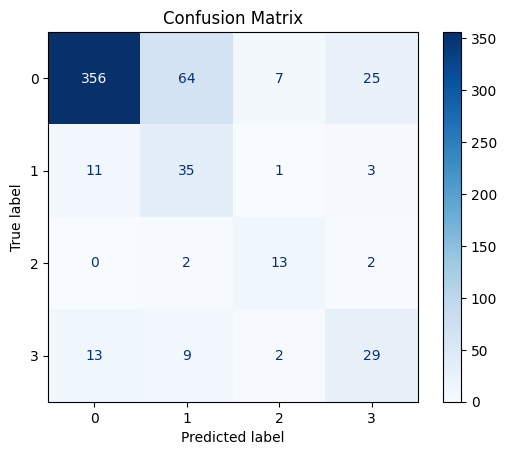

In [69]:
wandb.init()
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

# # Load the test dataset
# test_dataset = load_from_disk("/kaggle/working/validation_tokenized")

predictions = trainer2.predict(validation_tokenized)
final_predictions = np.argmax(predictions.predictions, axis=1)

label_map = {
    0: 'GENERAL',
    1: 'PROFANITY_0',
    2: 'PROFANITY_1',
    3: 'VIOLENCE'
}

prediction_data = []
for gt, pt in zip(validation_tokenized['labels'], final_predictions):
    prediction_data.append([gt, pt])
    
prediction_df = pd.DataFrame(prediction_data, columns=['labels', 'predictions'])
# Convert tensor labels to integers
prediction_df['labels'] = prediction_df['labels'].apply(lambda x: x.item() if isinstance(x, torch.Tensor) else x)

report = classification_report(y_true=prediction_df['labels'], y_pred=prediction_df['predictions'])
print(report)

# Confusion matrix
cm = confusion_matrix(y_true= prediction_df['labels'], y_pred= prediction_df['predictions'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(prediction_df['labels']))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

In [70]:
# Saving the best model to hub
trainer2.save_model("best_model")
trainer2.push_to_hub("Vyke2000/BERT_v2")

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.30k [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

events.out.tfevents.1738318837.f92e2c842e43.31.0:   0%|          | 0.00/486 [00:00<?, ?B/s]

events.out.tfevents.1738318996.f92e2c842e43.31.1:   0%|          | 0.00/486 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Vyke2000/tmp/commit/fe3d45a1a966ce03ed1ae6f0c10a201637d619f6', commit_message='Vyke2000/BERT_v2', commit_description='', oid='fe3d45a1a966ce03ed1ae6f0c10a201637d619f6', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Vyke2000/tmp', endpoint='https://huggingface.co', repo_type='model', repo_id='Vyke2000/tmp'), pr_revision=None, pr_num=None)